In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from dtaidistance import dtw



In [2]:
file_path = 'D:\Hiwi-TimeSeries\dataset\Versuch1_final.csv'
df = pd.read_csv(file_path, delimiter=';', decimal=',')
df = df.head(100000)

## Functions

In [3]:
def rename_columns(dataframe):
    renamed_columns = []
    for column in dataframe.columns:
        parts = column.split('_')
        if len(parts) >= 3:
            if parts[0] == 'Geschw':
                new_column = 'Speed_' + parts[1]
            elif parts[0] == 'Beschl':
                new_column = 'Accel_' + parts[1]
            elif parts[0] == 'Kraft':
                new_column = 'Power_' + parts[1]
            elif parts[0] == 'Current':
                new_column = 'Current_' + parts[1]
        else:
            new_column = column
        renamed_columns.append(new_column)
    
    dataframe.columns = renamed_columns
    return dataframe

In [8]:
def plot_prediction(y_test, y_pred, title):
    plt.figure(figsize=(16, 4))
    num_points = min(len(y_test), 10000)
    x_values = np.arange(num_points)
    plt.plot(x_values, y_test[:num_points], label='Actual Current', alpha=0.7)
    plt.plot(x_values, y_pred[:num_points], label='Predicted Current', alpha=0.5)
    plt.ylim(0, 30)  # Set y-axis limits from 0 to 30
    plt.xlabel('Index')
    plt.ylabel('Current')
    plt.title('Actual vs. Predicted Current - ' + title)
    plt.legend()
    plt.show()


In [5]:
def fit_predict(model, X_train, X_test, y_train, y_test, title):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    #print(y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    #dtw_dist = dtw_distbance(y_test, y_pred)

    print("Mean Absolute Error:", mae)
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", np.sqrt(mse))
    print("R-squared Score:", r2)
    print("Mean Absolute Percentage Error:", mape)
    #print("DTW Distance:", dtw_dist)

    plot_prediction(y_test, y_pred, title)
    #return y_pred
    #residual_analysis(y_test, y_pred)

## Pre-processing and Data Split

In [6]:
df.drop('removed_material_0', axis=1, inplace=True)
df = rename_columns(df)

In [7]:
X = df.drop(columns=['Current_X', 'Current_Y', 'Current_Z', 'Current_SP'])
y = df[['Current_X', 'Current_Y', 'Current_Z', 'Current_SP']].sum(axis=1)
split_index = int(0.7 * len(df))

X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]
#X_train.loc[:, 'Current'] = y_train


# Baseline Model

## Random Forest Regressor

In [10]:
# Found out using GridSearchCV

best_grid = RandomForestRegressor(bootstrap= False, max_depth= 20, max_features= 'log2', min_samples_leaf= 1,
 min_samples_split= 2, n_estimators= 1500)

Mean Absolute Error: 0.11205127343163165
Mean Squared Error: 0.216247116245074
Root Mean Squared Error: 0.4650237803006143
R-squared Score: 0.7788484003295595
Mean Absolute Percentage Error: 1.7091888057960705


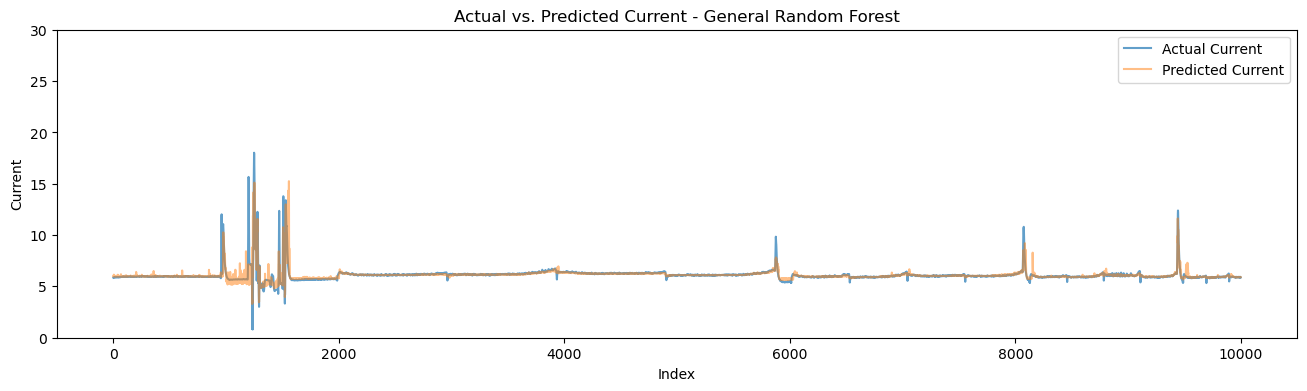

In [11]:
fit_predict(best_grid, X_train, X_test, y_train, y_test, 'General Random Forest')

# Peak Detection

In [36]:
def detect_peaks(y, lag, percent):
    peaks = []
    threshold = np.mean(y[:lag])
    for i in range(len(y)):
        if y[i] > threshold*percent:
            peaks.append(i)
        threshold = np.mean(y[i:lag+i])
    return peaks


In [33]:
def get_peak_indices_by_column(dataframe, lag, percent):
    peak_indices_by_column = {}

    for column_name in dataframe.columns:
        result = detect_peaks(dataframe[column_name], lag, percent)
        peak_indices_by_column[column_name] = result

    return peak_indices_by_column

In [34]:
import itertools

def find_common_peaks(peaks_df):
    common_peaks = []
    
    columns = peaks_df['Column_Name'].tolist()
    columns.remove('Current')
    column_combinations = [(column, 'Current') for column in columns]   

    for pair in column_combinations:
        column1_peaks = set(peaks_df.loc[peaks_df['Column_Name'] == pair[0], 'Peak_Indices'].iloc[0])
        column2_peaks = set(peaks_df.loc[peaks_df['Column_Name'] == pair[1], 'Peak_Indices'].iloc[0])
        
        common_indices = list(column1_peaks.intersection(column2_peaks))
        num_common_peaks = len(common_indices)
        
        common_peaks.append({'feature_pair': pair, 'peak_indices': common_indices, 'num_peaks': num_common_peaks})
    
    return pd.DataFrame(common_peaks)

In [41]:
def plot_common_peaks(df, common_peaks_df, lag, percent):
    for index, row in common_peaks_df.iterrows():
        pair = row['feature_pair']
        common_indices = sorted(row['peak_indices'])
        
        values_column1 = []
        index_column = []
        values_column2 = []
        
        for index_value in common_indices:
            # Extract values for both columns from 10 indices before and after the common index
            values_column1.extend(df.loc[index_value - 10:index_value + 10, pair[0]].tolist())
            values_column2.extend(df.loc[index_value - 10:index_value + 10, pair[1]].tolist())
            if index_value > 10:
                index_column.extend(list(range(index_value - 10, index_value + 11)))
                
        #values_column1 = (values_column1 - np.min(values_column1)) / (np.max(values_column1) - np.min(values_column1))
        #values_column2 = (values_column2 - np.min(values_column2)) / (np.max(values_column2) - np.min(values_column2))
        values_column1 = [(value - np.min(values_column1)) / (np.max(values_column1) - np.min(values_column1)) for value in values_column1]
        values_column2 = [(value - np.min(values_column2)) / (np.max(values_column2) - np.min(values_column2)) * (2 - 1) + 1 for value in values_column2]
        plt.figure(figsize=(12, 4))
        plt.plot(index_column, values_column1, label=pair[0])
        plt.plot(index_column, values_column2, label=pair[1])
    
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.title('Common Peaks --' + str(row['num_peaks']) +' (Lag = ' + str(lag) +'Peak% = ' + str(percent)+ ')')
        plt.legend()
        plt.show()


In [42]:
def get_output_peaks(df, lag, percent):  
    peak_info = get_peak_indices_by_column(df, lag, percent)
    peaks_df = pd.DataFrame({'Column_Name': list(peak_info.keys()), 
                                'Peak_Indices': list(peak_info.values())})
    peaks_df['Num_Peaks'] = peaks_df['Peak_Indices'].apply(len)
    peaks_df = peaks_df[~peaks_df['Column_Name'].str.startswith('Power')]
    #print(peaks_df.head(10))

    common_peaks_df = find_common_peaks(peaks_df)
    plot_common_peaks(df, common_peaks_df, lag, percent)
    #print(common_peaks_df)

    import os
    output_folder = 'D:\Hiwi-TimeSeries\output'

    filename = os.path.join(output_folder, f'common_peaks_l_{lag}_p_{percent}.xlsx')
    common_peaks_df.to_excel(filename, sheet_name='common_peaks', index=False)
    print("Currently on lag:", lag)


In [43]:
pi= get_peak_indices_by_column(df, 10000, 1.1)

KeyboardInterrupt: 

In [39]:
peaks_df = pd.DataFrame({'Column_Name': list(pi.keys()), 
                                'Peak_Indices': list(pi.values())})
peaks_df['Num_Peaks'] = peaks_df['Peak_Indices'].apply(len)
peaks_df = peaks_df[~peaks_df['Column_Name'].str.startswith('Power')]
print(peaks_df)

   Column_Name                                       Peak_Indices  Num_Peaks
0      Speed_X  [599, 600, 601, 602, 603, 604, 605, 606, 607, ...      50092
1      Speed_Y  [599, 600, 601, 602, 603, 604, 605, 606, 607, ...      24379
2      Speed_Z  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...      51018
3     Speed_SP  [6869, 6870, 6871, 6872, 6873, 6874, 6875, 687...      20411
4      Accel_X  [0, 1, 2, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, ...      51061
5      Accel_Y  [7, 14, 16, 17, 21, 25, 30, 35, 37, 41, 42, 45...      49158
6      Accel_Z  [0, 1, 2, 4, 6, 9, 10, 12, 14, 16, 21, 25, 27,...      52306
7     Accel_SP  [648, 649, 650, 651, 652, 653, 654, 655, 656, ...      22620
12   Current_X  [576, 577, 578, 579, 580, 581, 582, 583, 584, ...      41405
13   Current_Y  [160, 161, 162, 163, 164, 165, 166, 167, 168, ...      31548
14   Current_Z  [360, 361, 362, 363, 364, 365, 366, 379, 380, ...       1661
15  Current_SP  [628, 629, 630, 631, 632, 633, 634, 635, 636, ...      42606

### Peaks in the training data

In [45]:
X_train.loc[:, 'Current'] = y_train

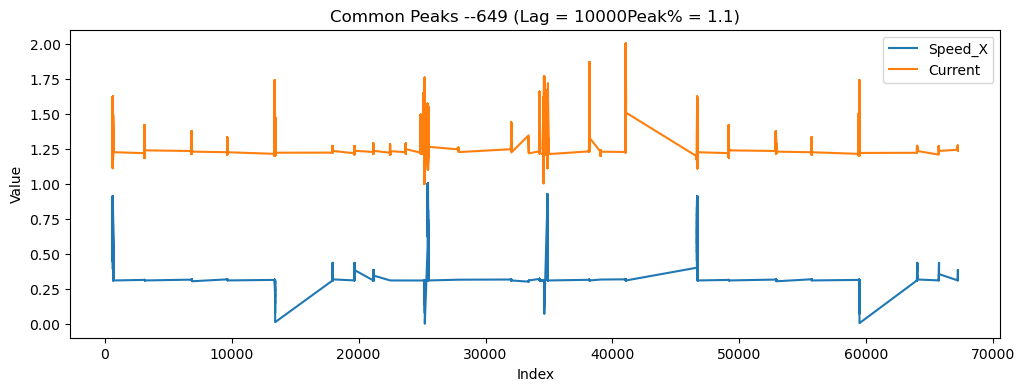

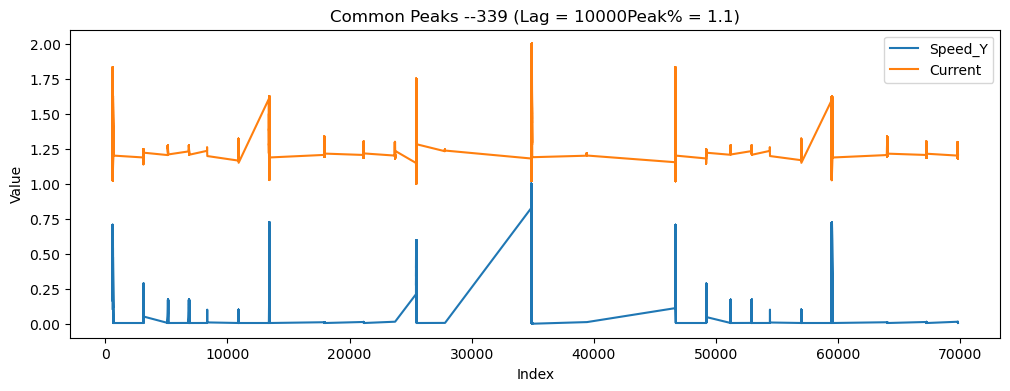

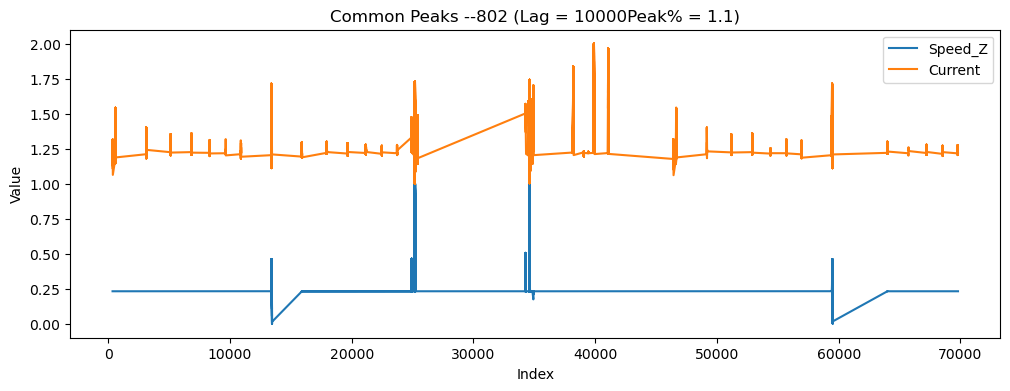

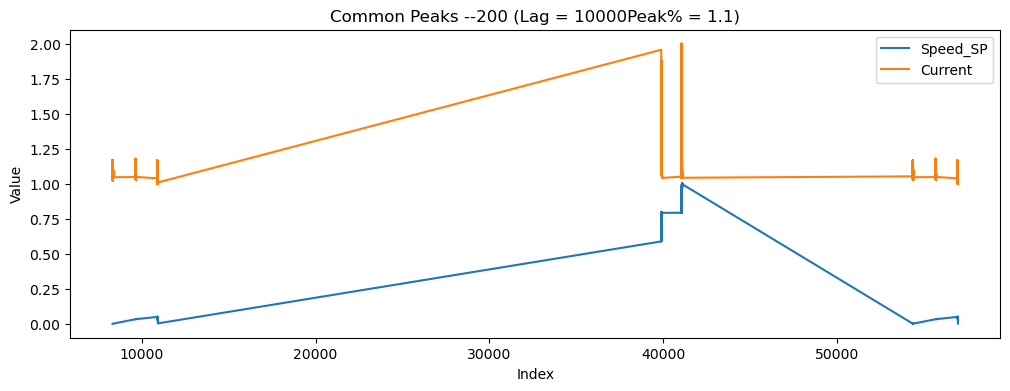

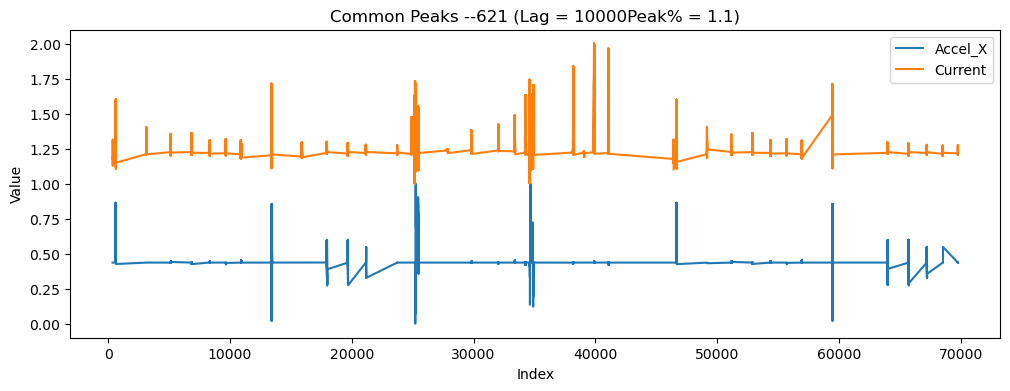

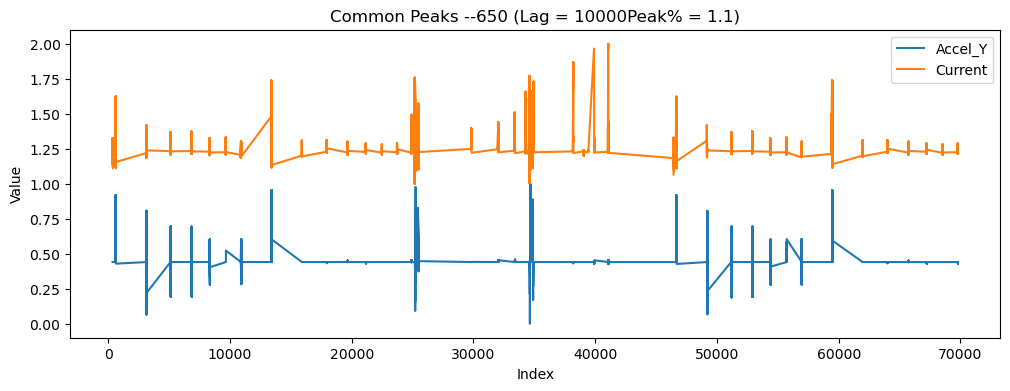

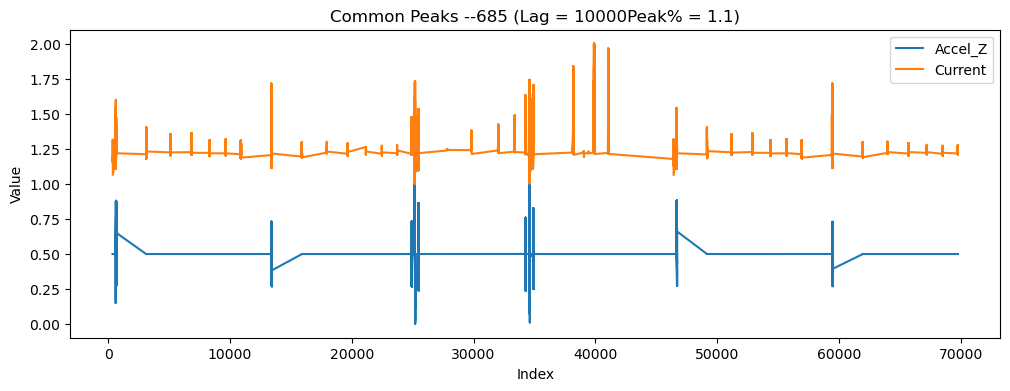

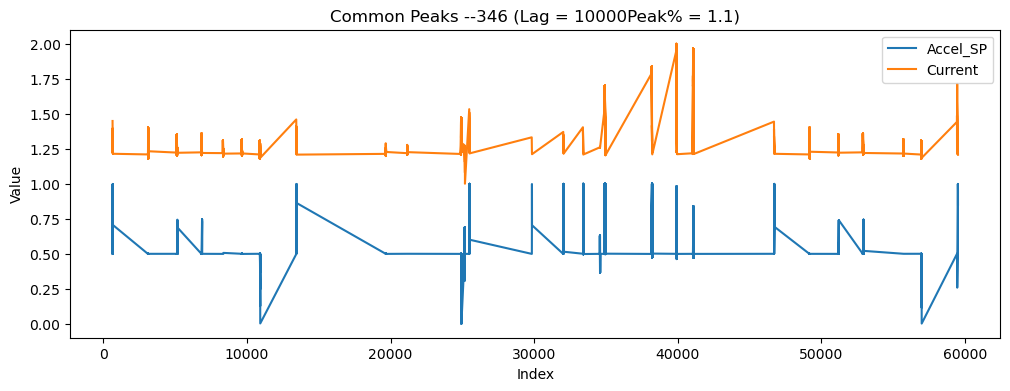

Currently on lag: 10000


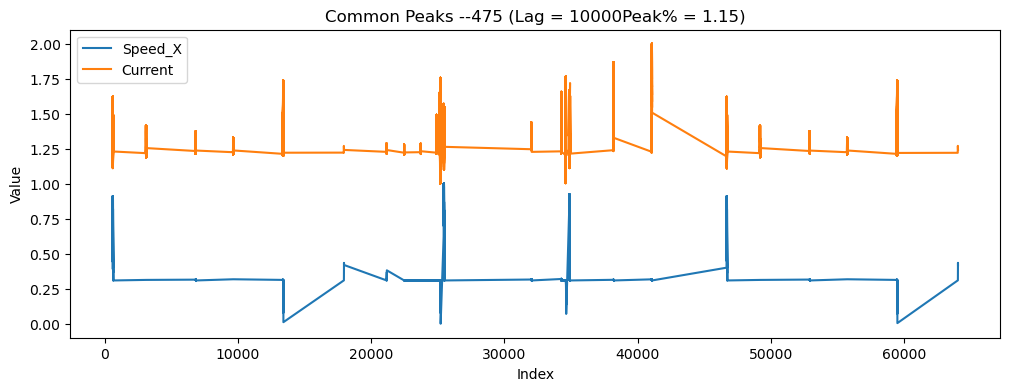

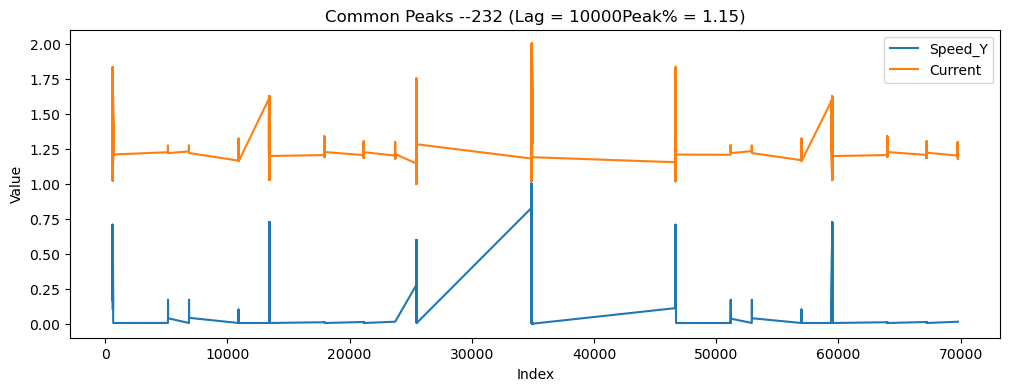

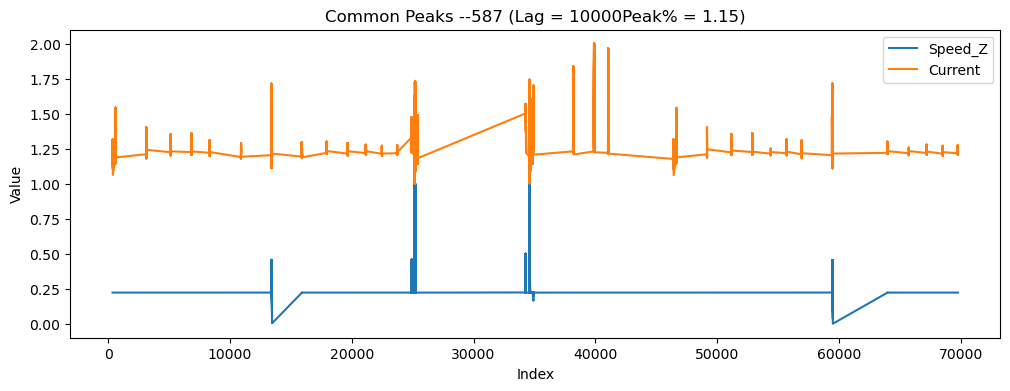

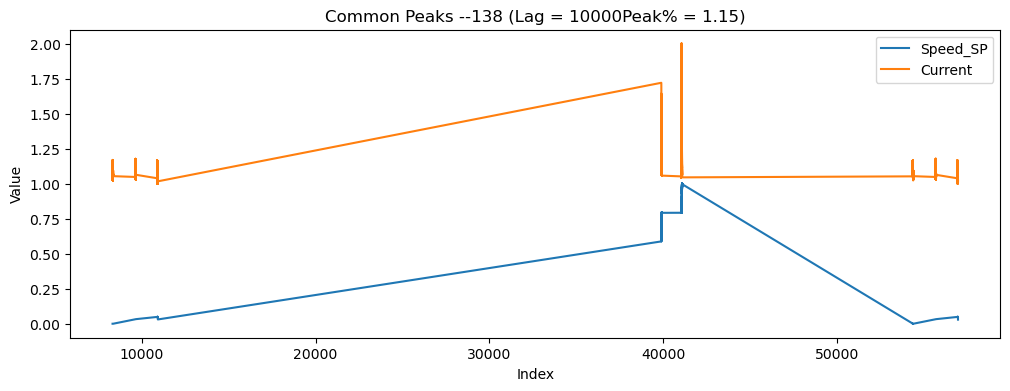

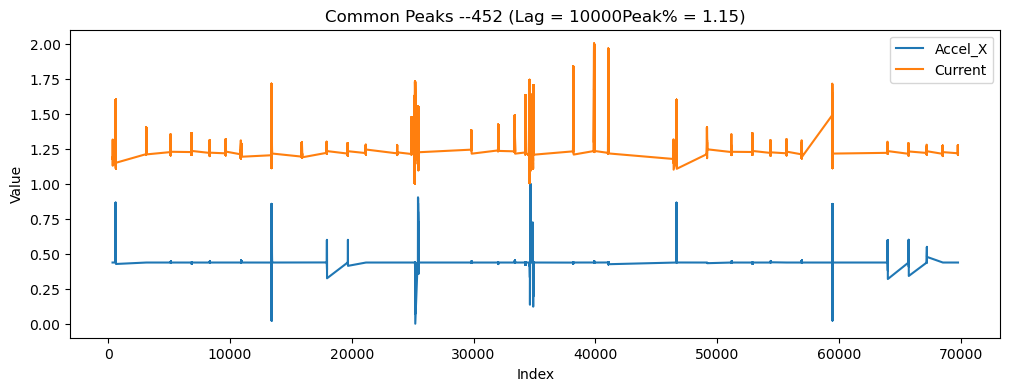

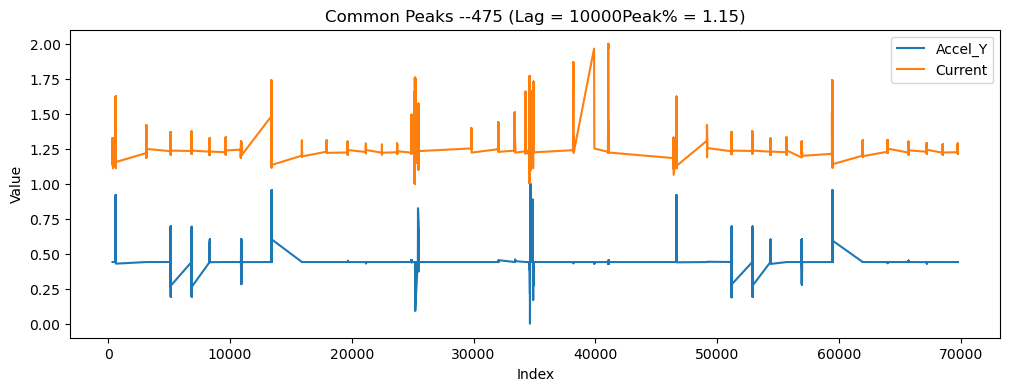

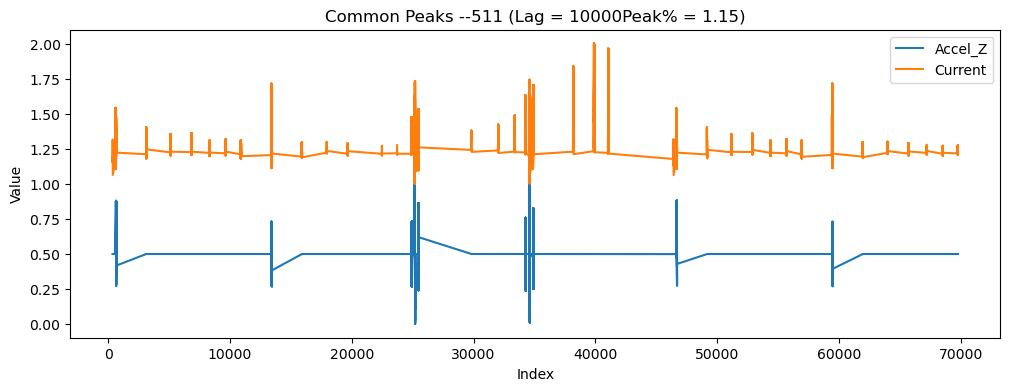

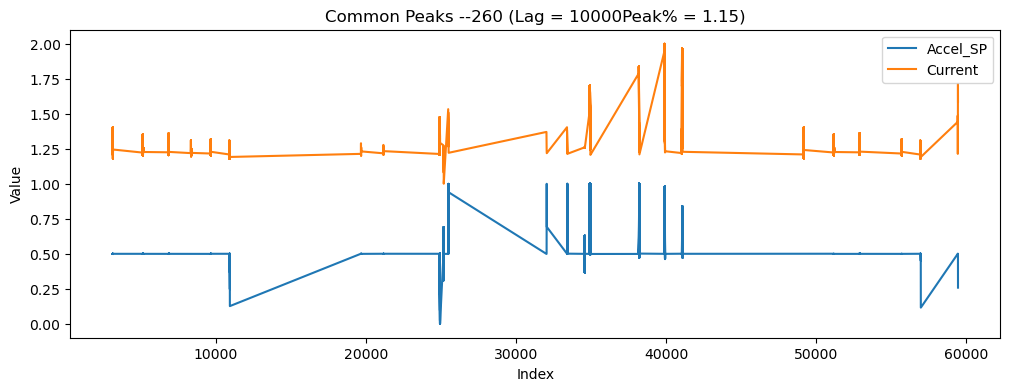

Currently on lag: 10000


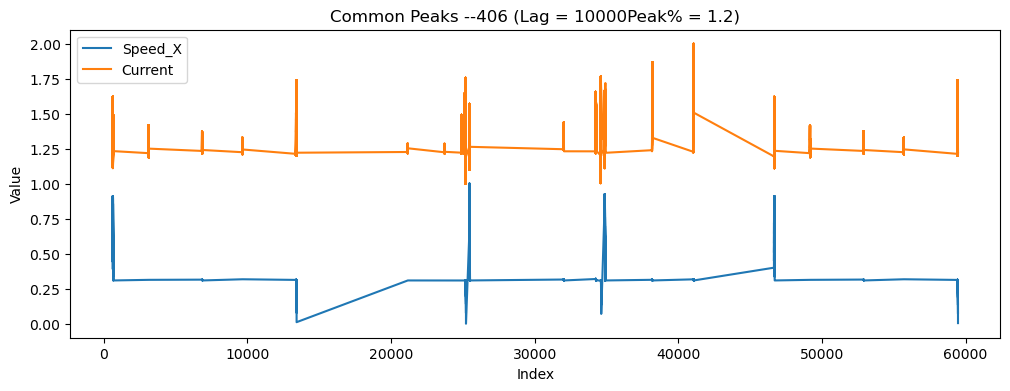

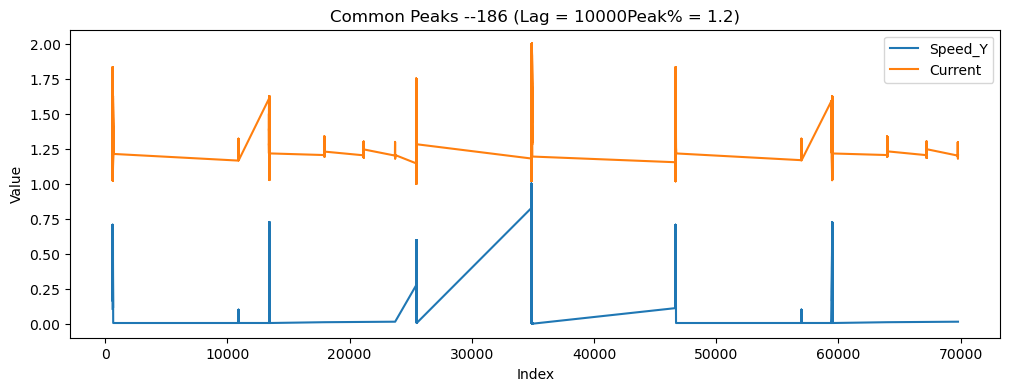

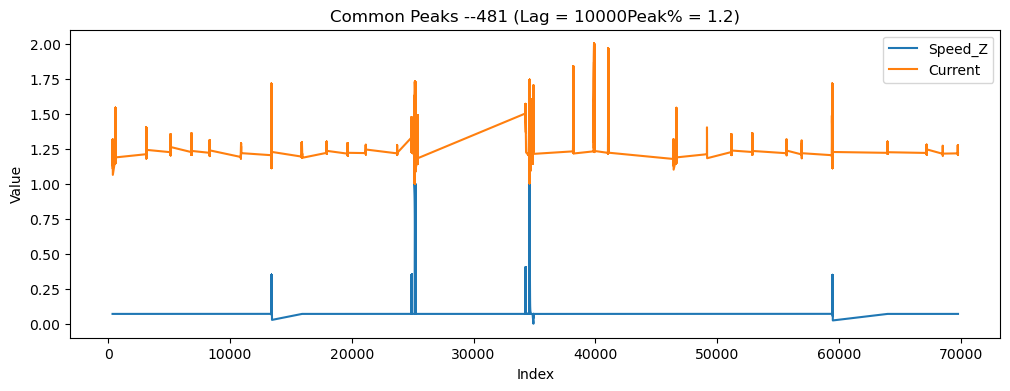

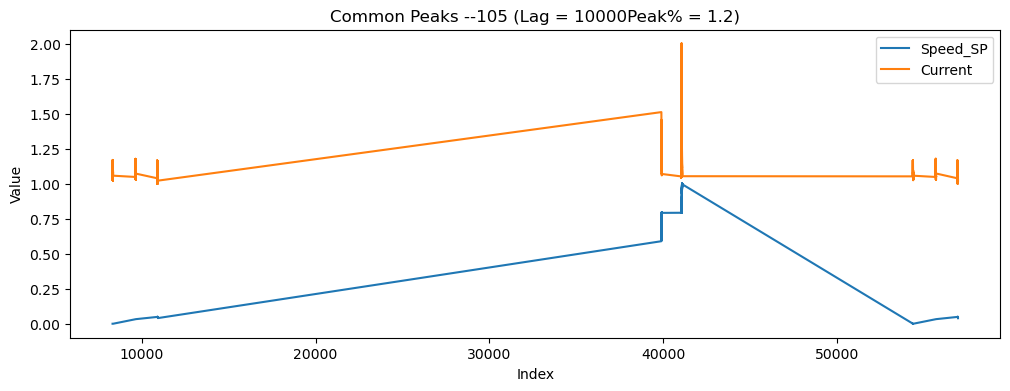

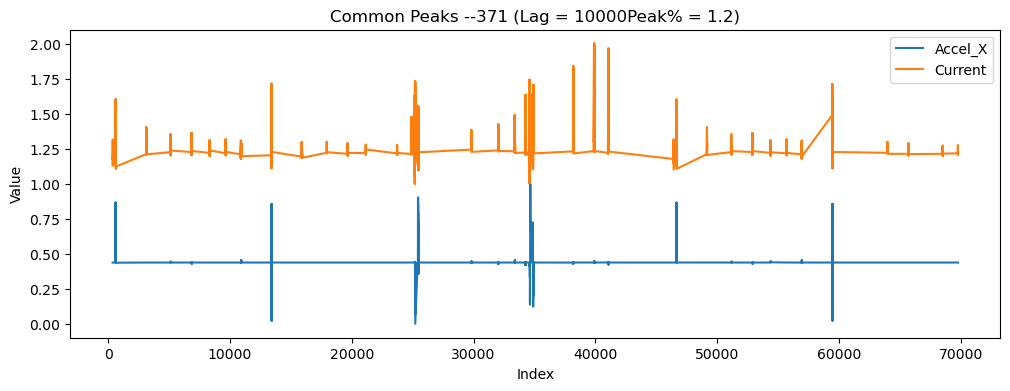

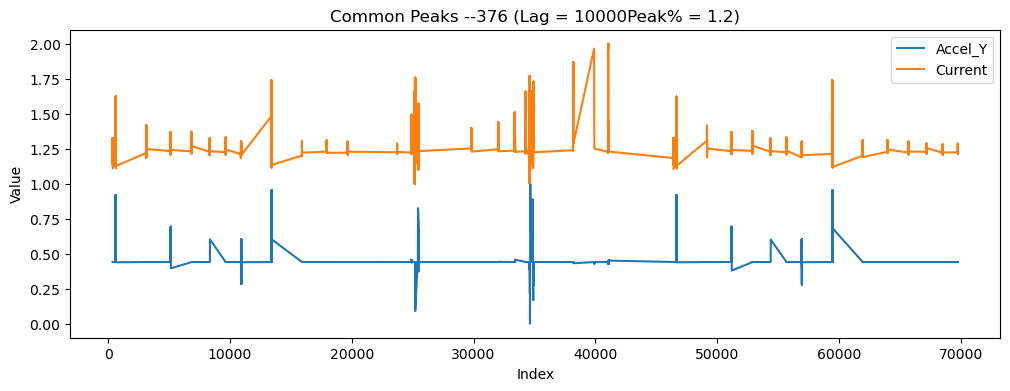

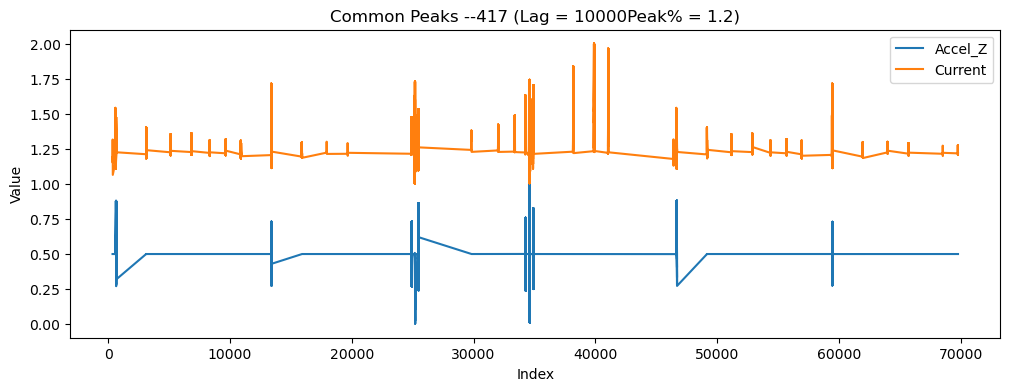

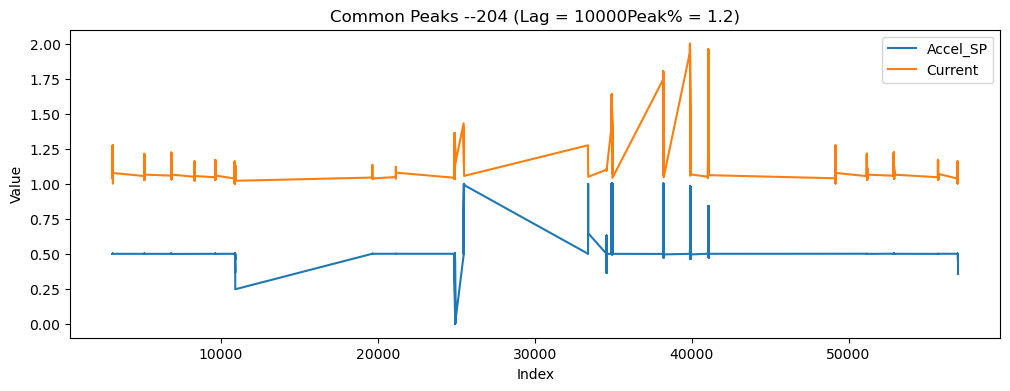

Currently on lag: 10000


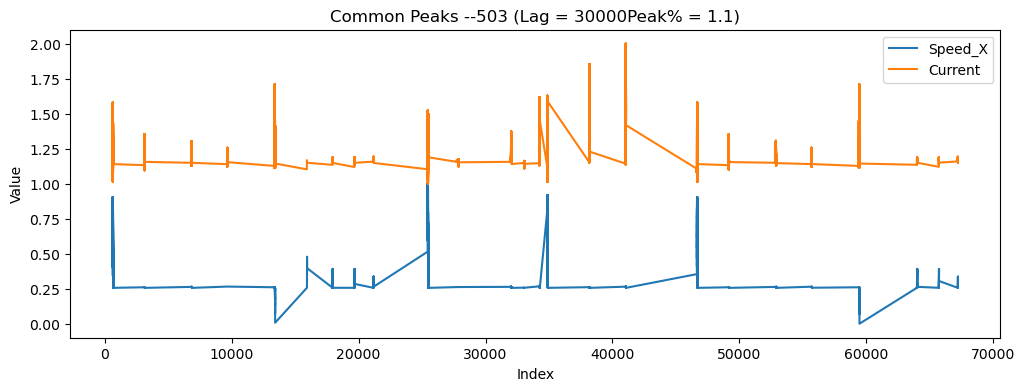

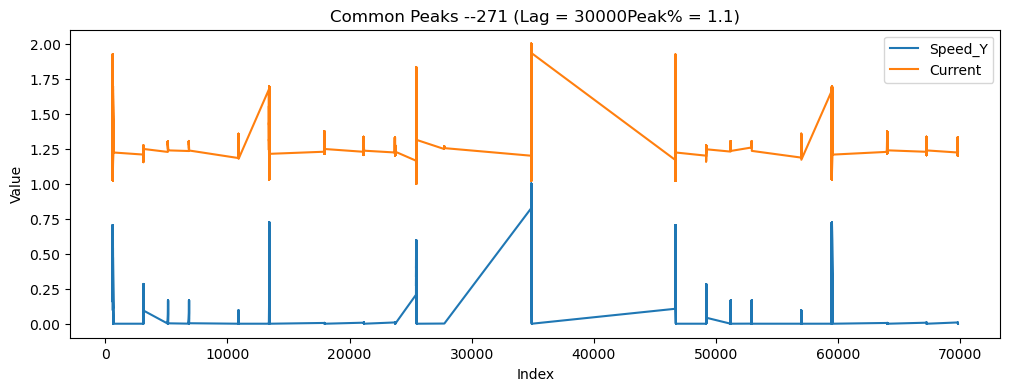

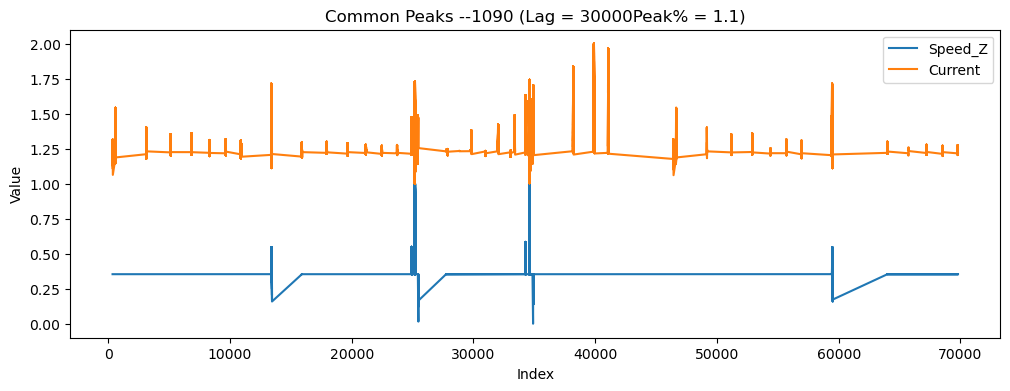

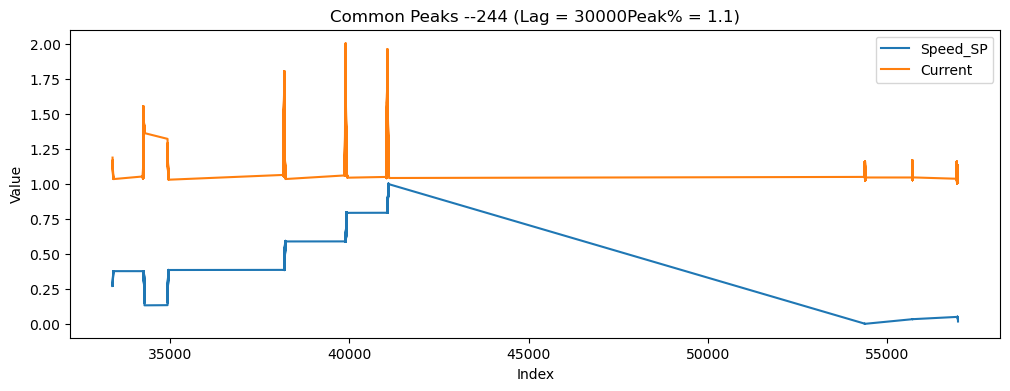

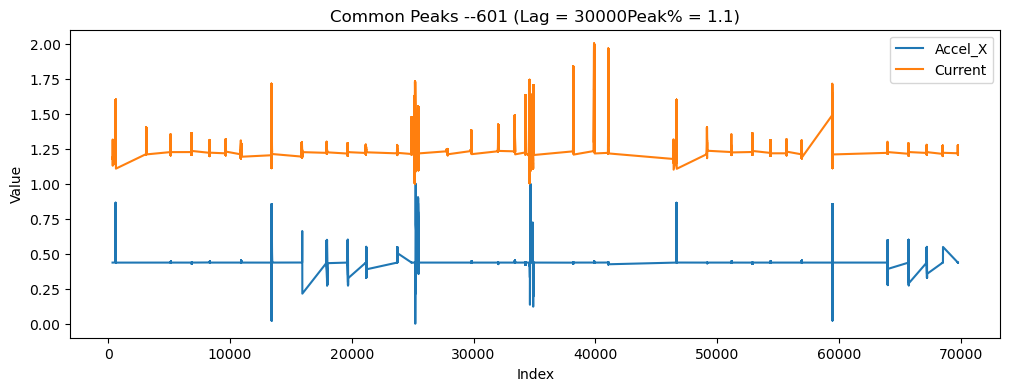

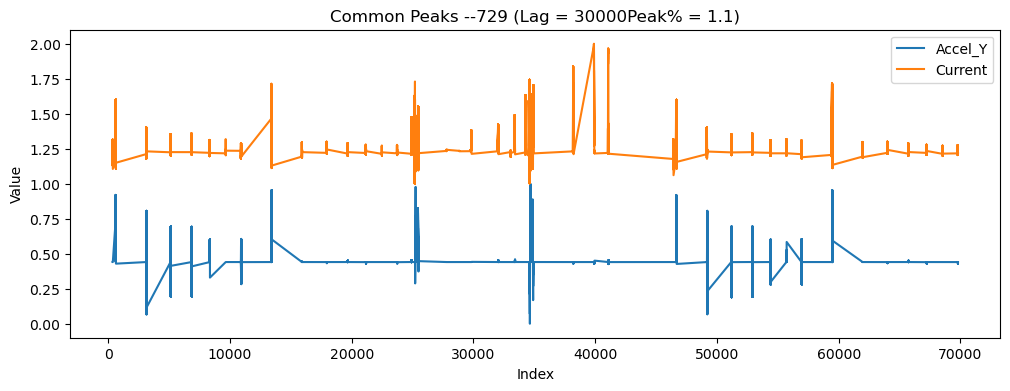

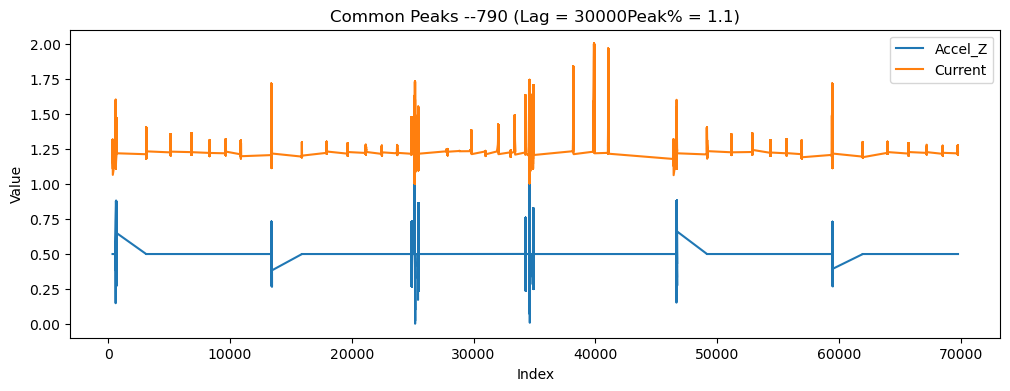

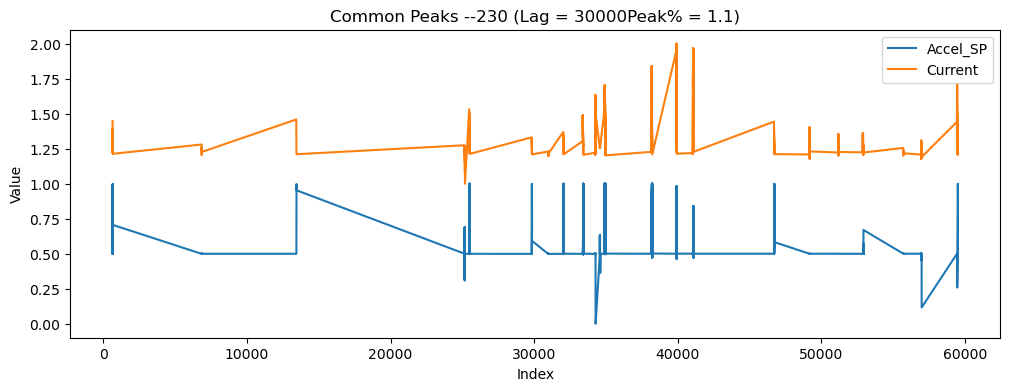

Currently on lag: 30000


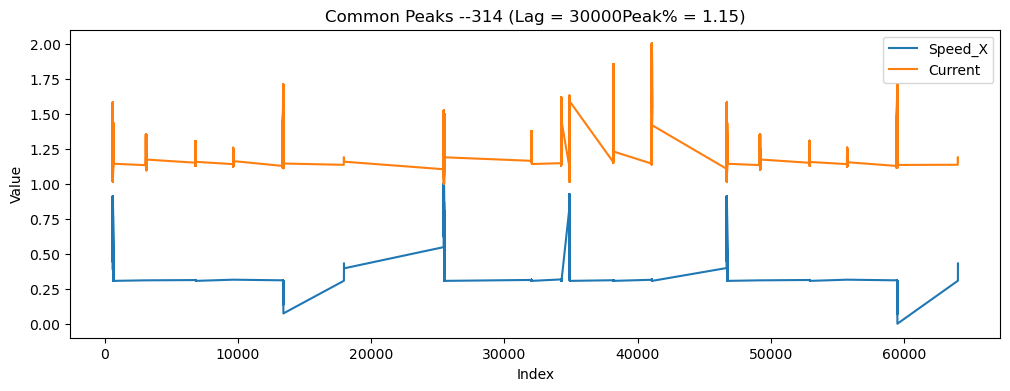

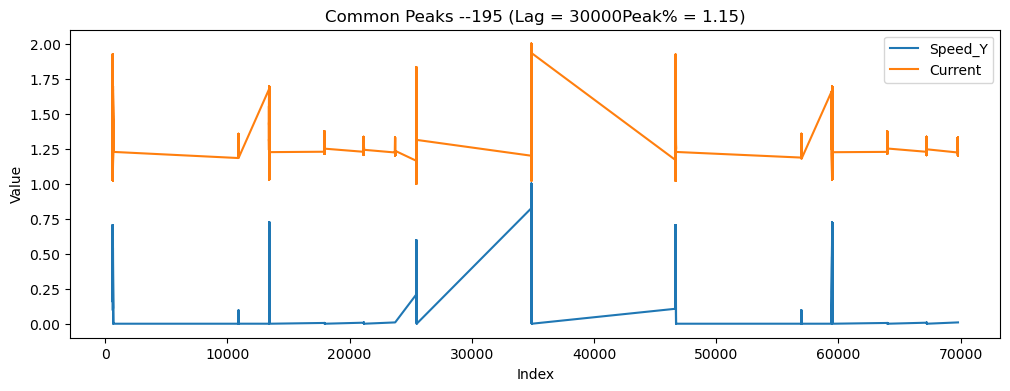

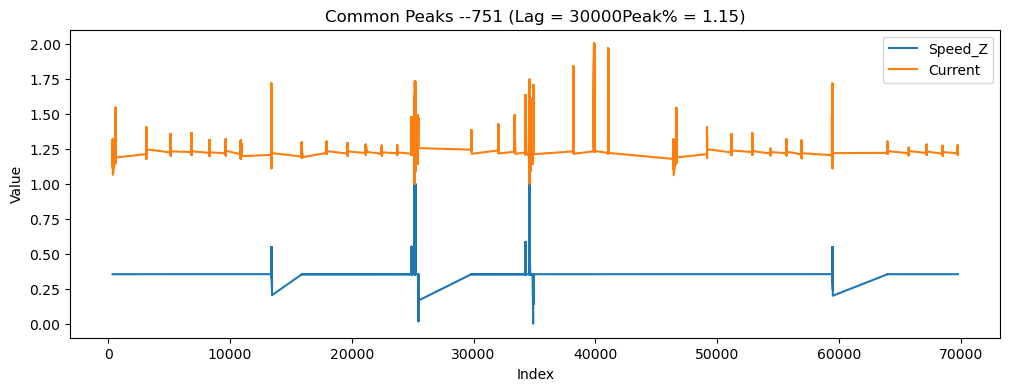

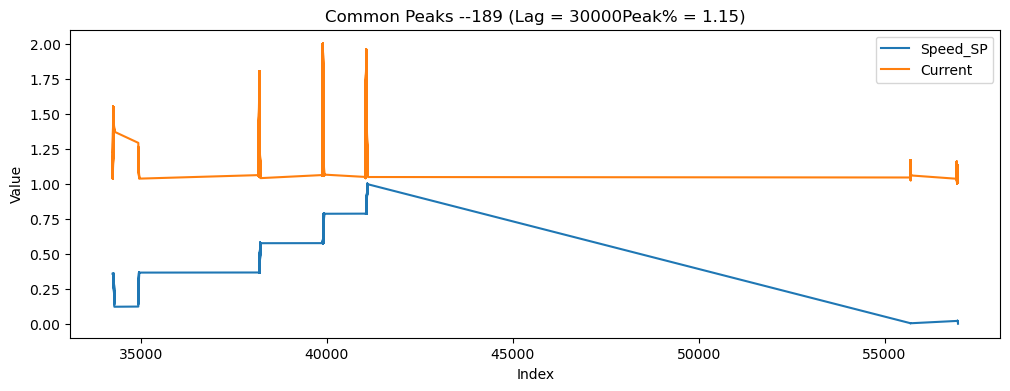

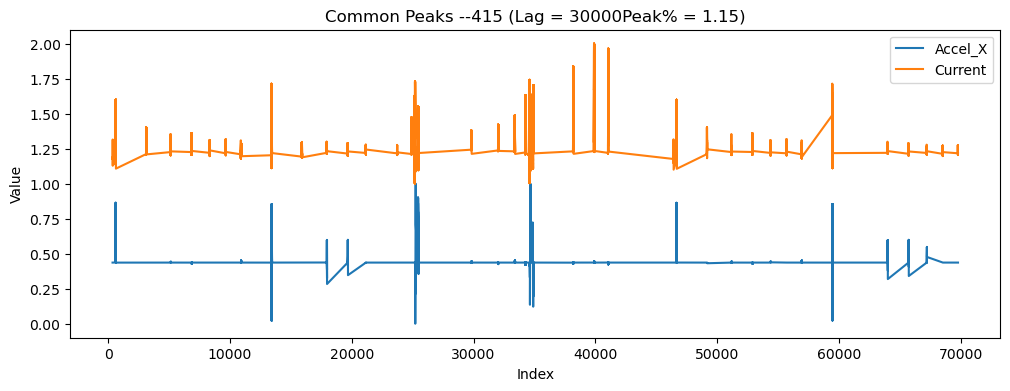

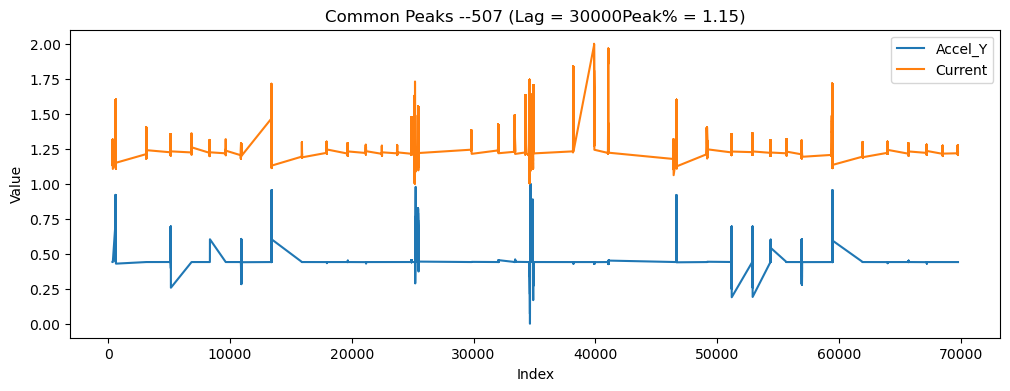

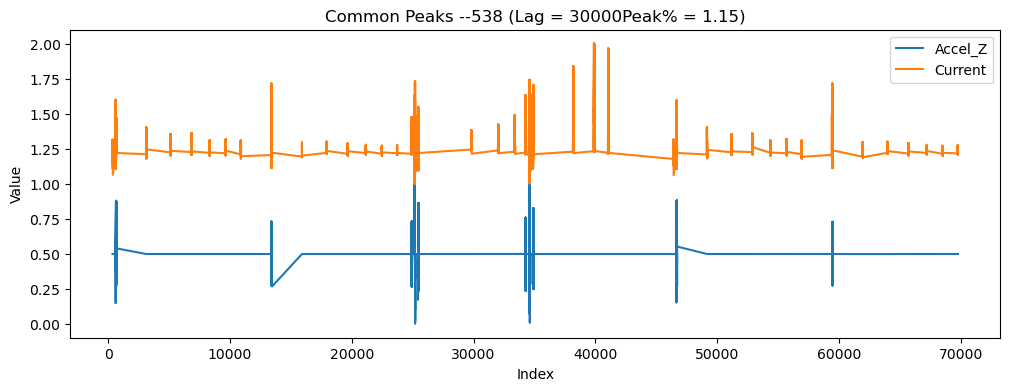

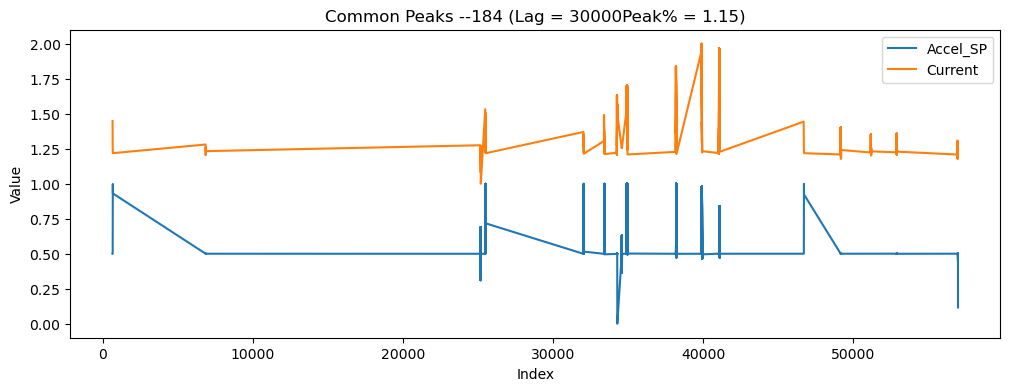

Currently on lag: 30000


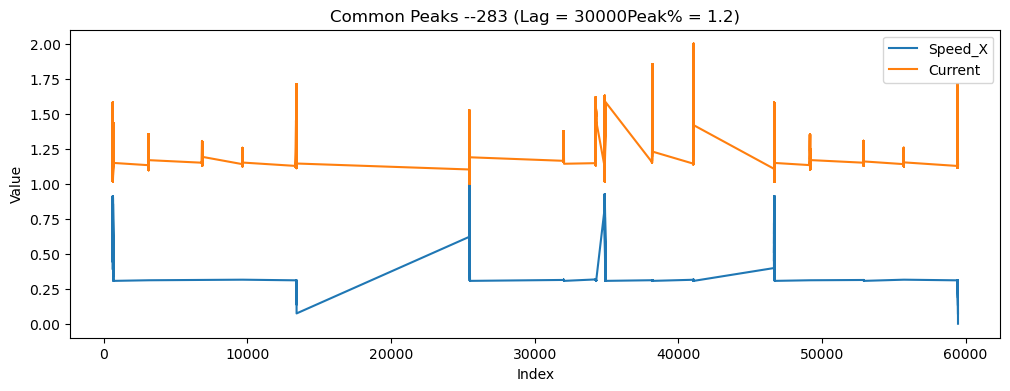

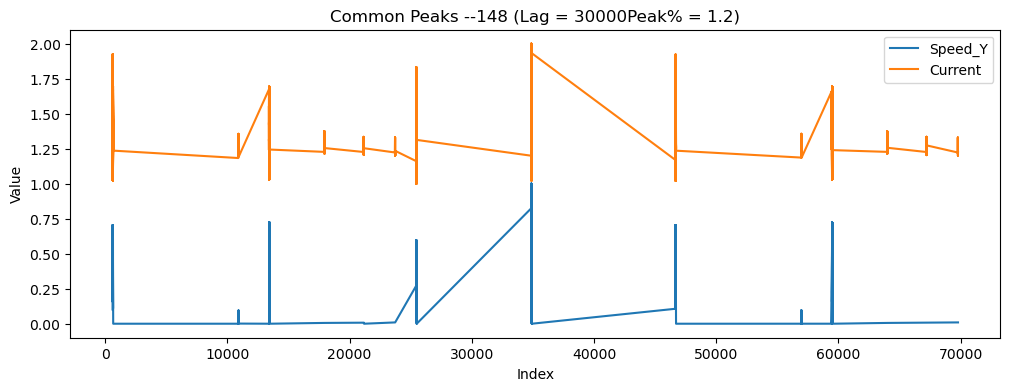

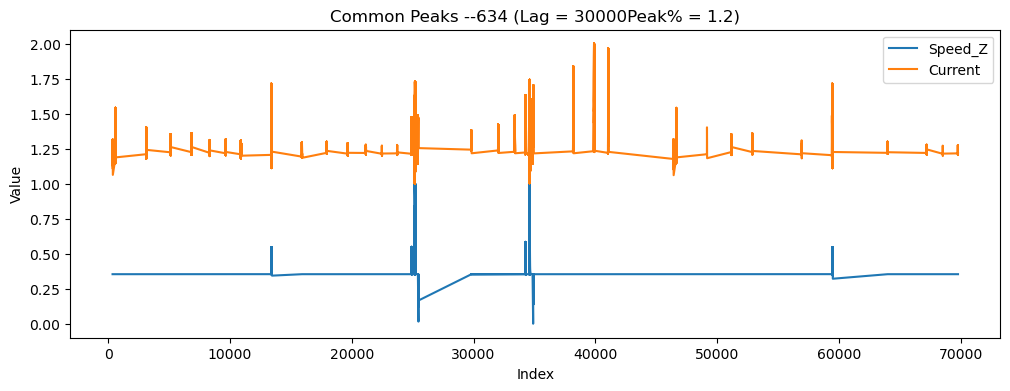

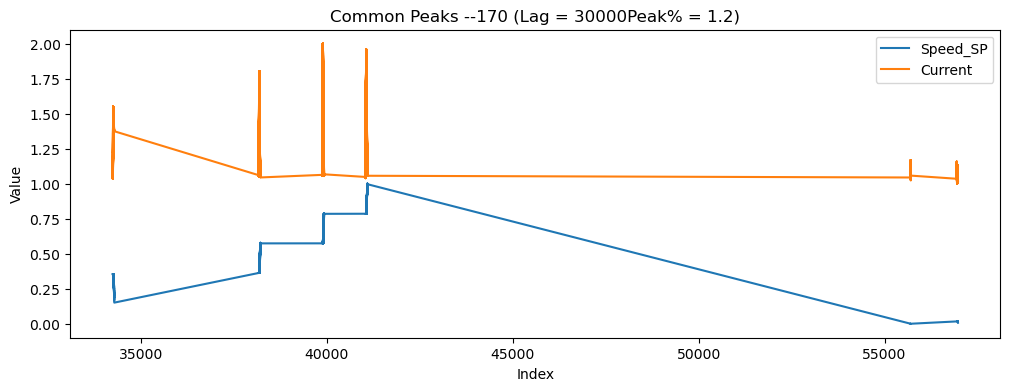

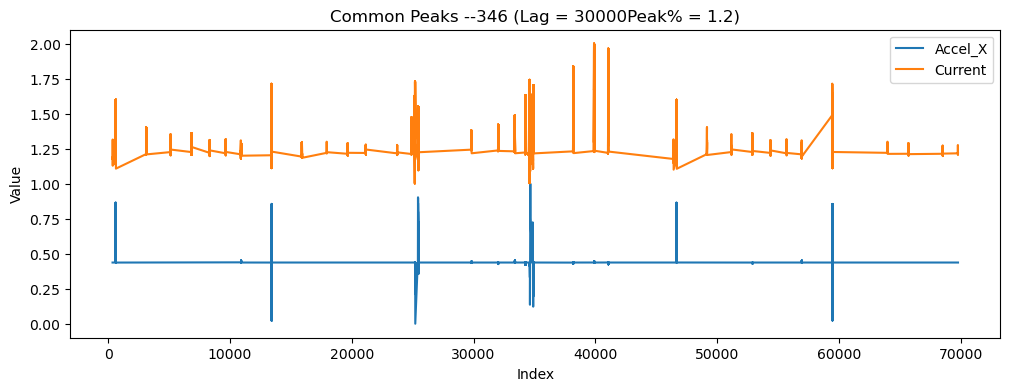

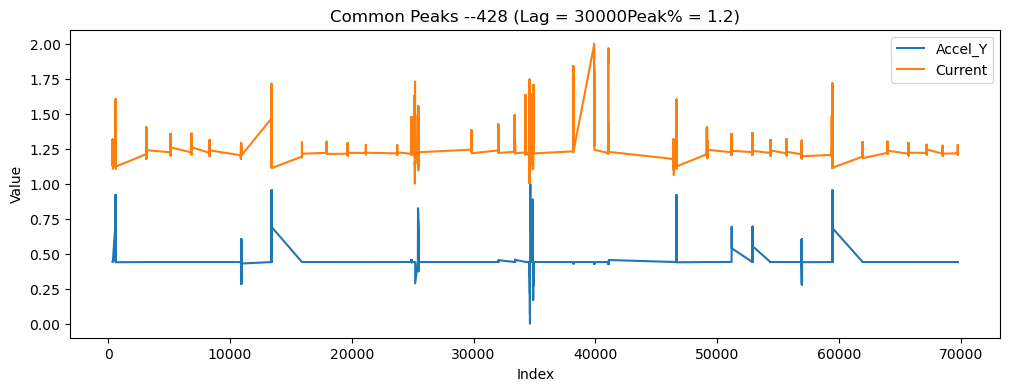

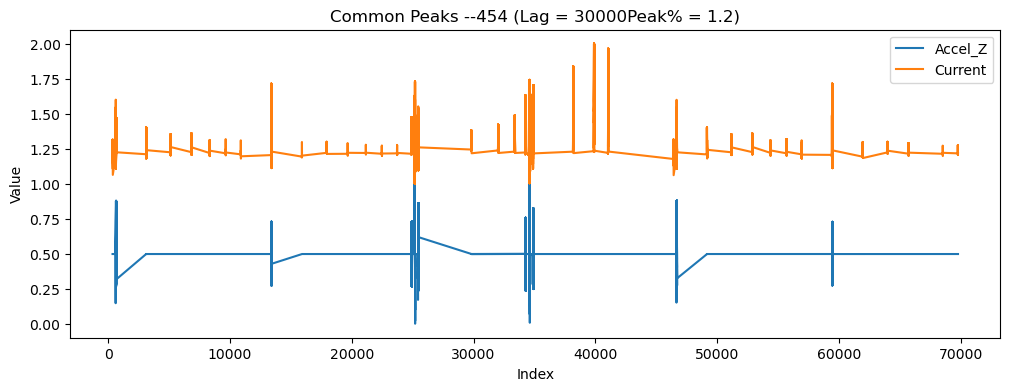

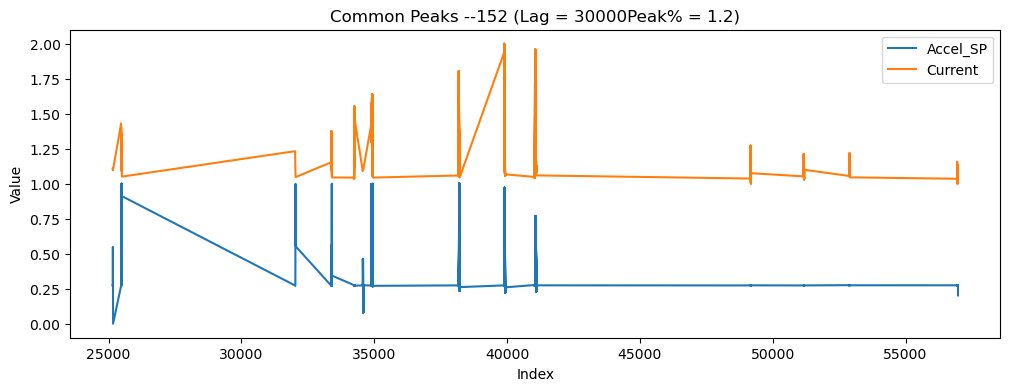

Currently on lag: 30000


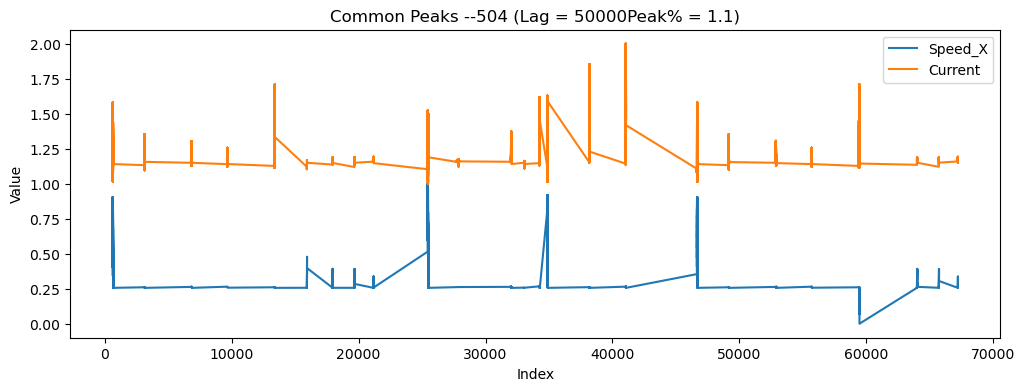

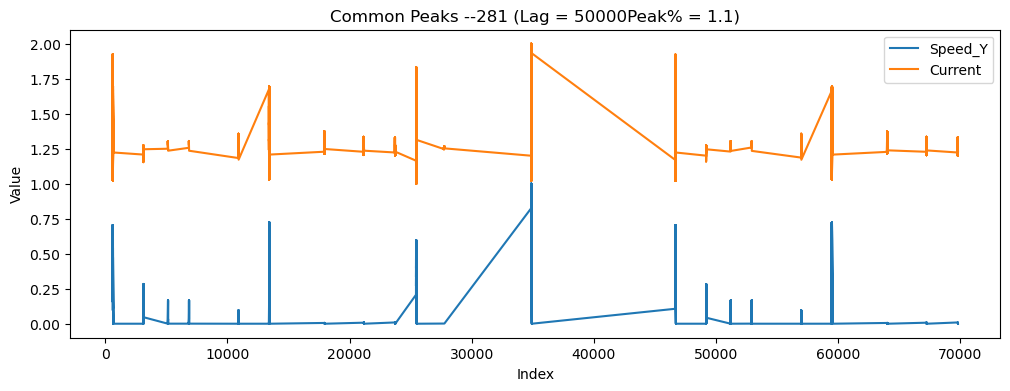

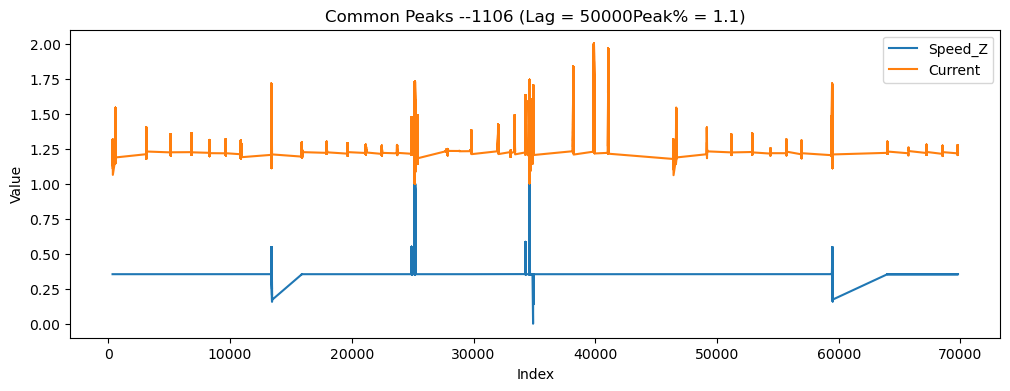

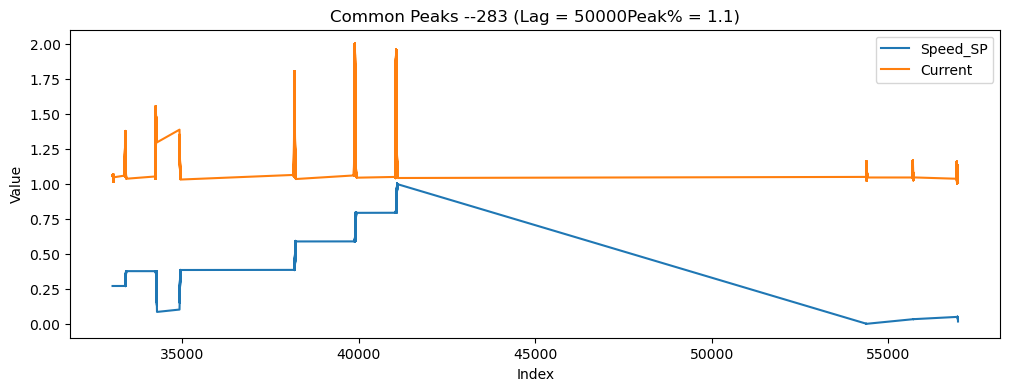

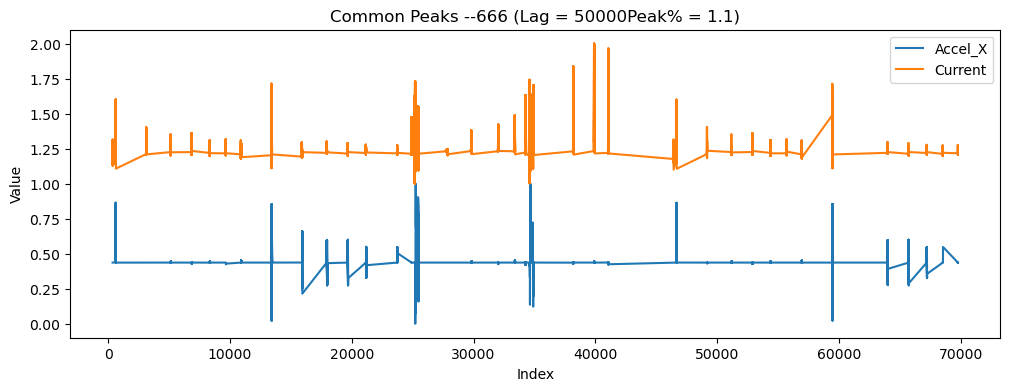

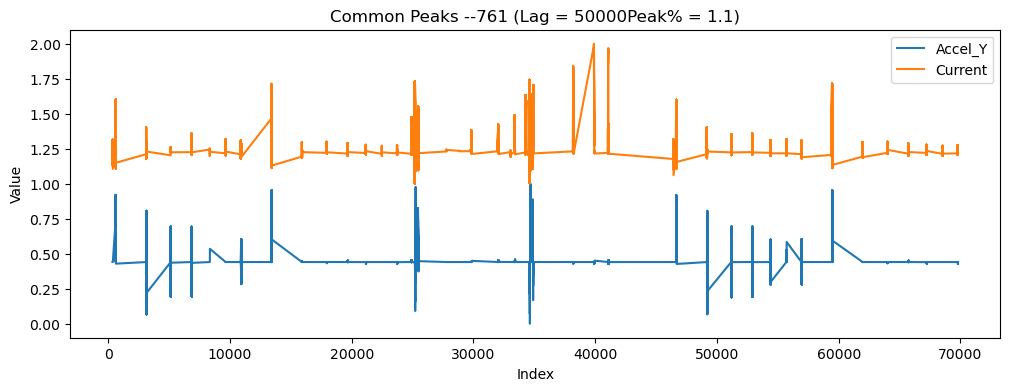

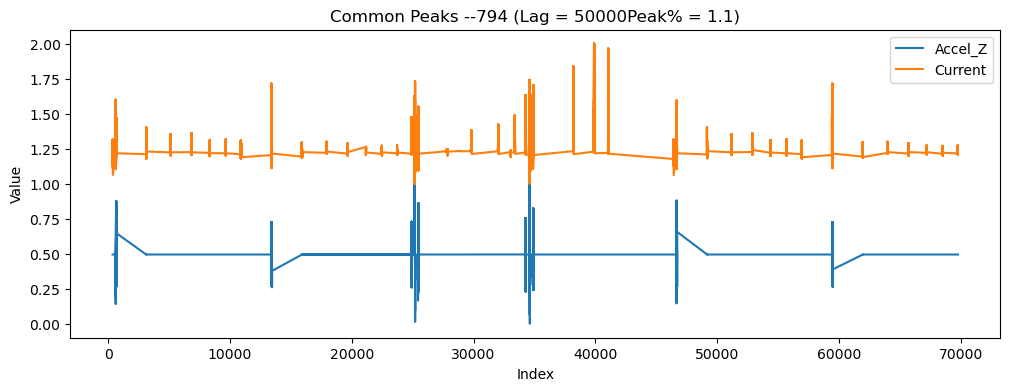

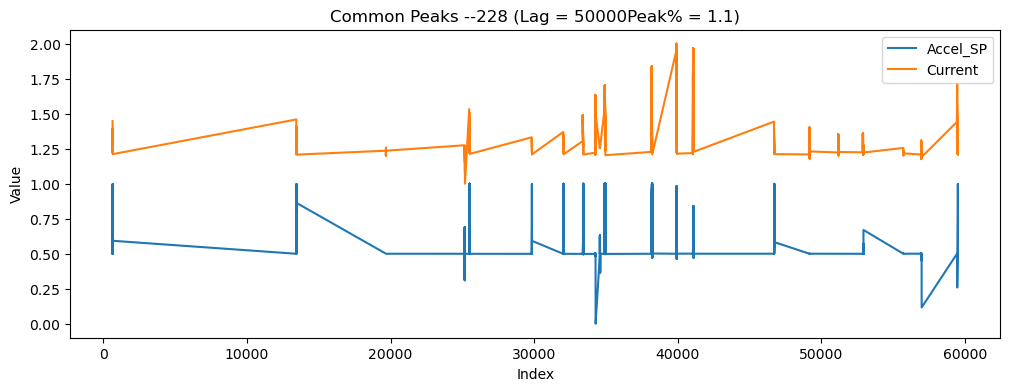

Currently on lag: 50000


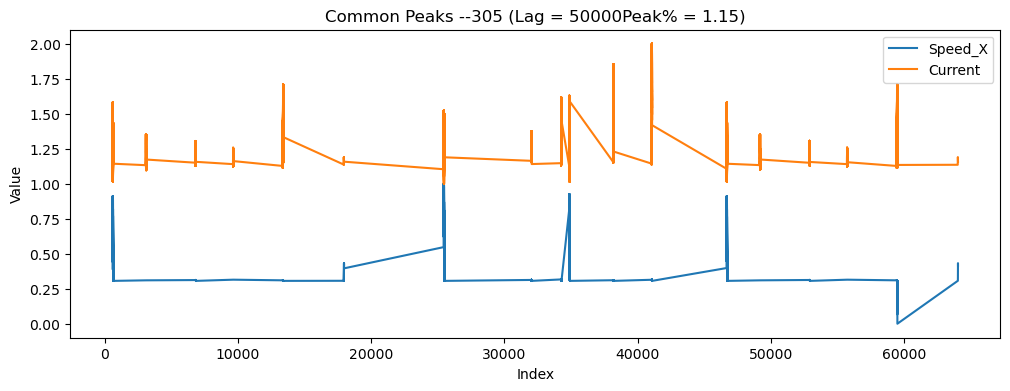

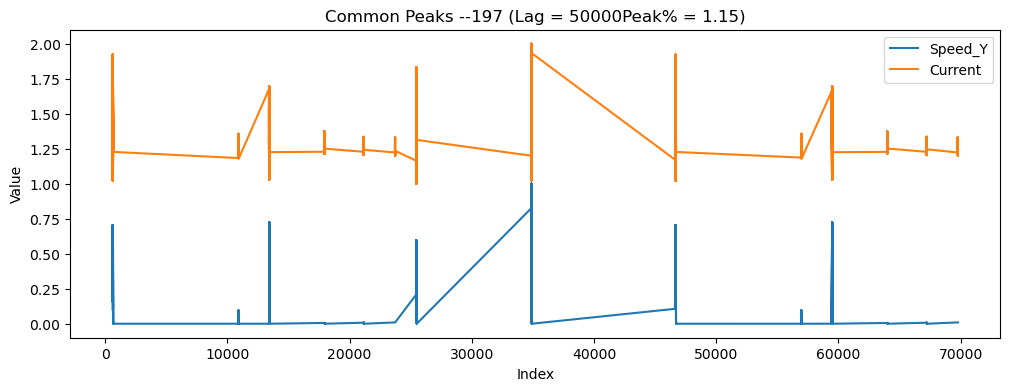

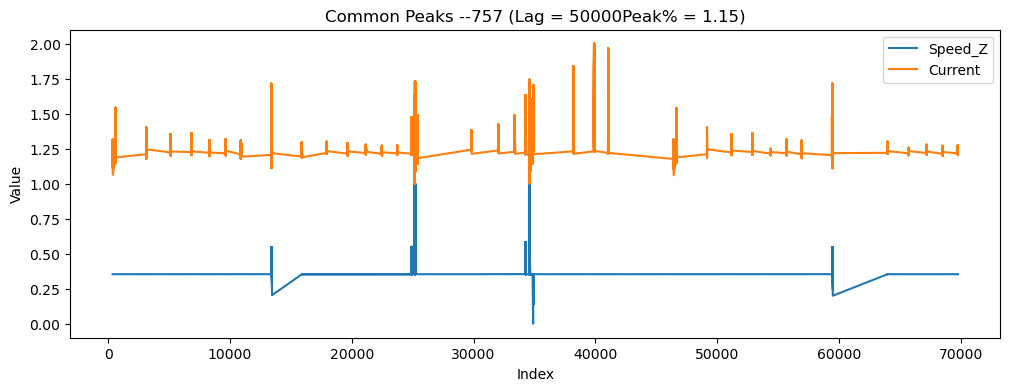

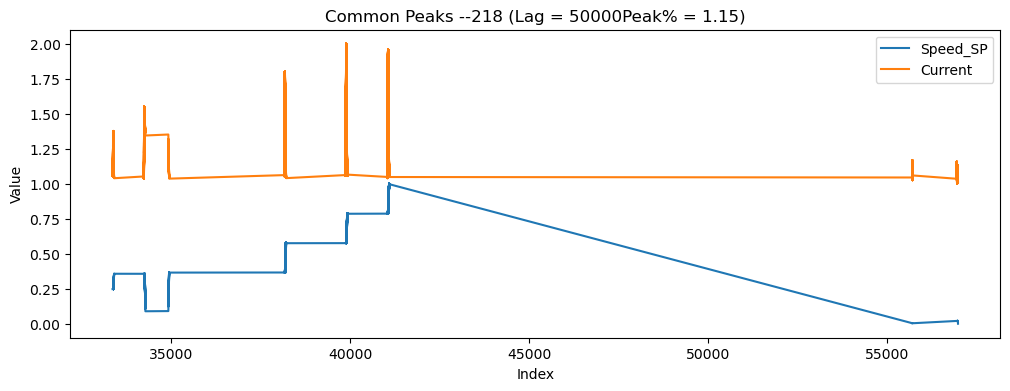

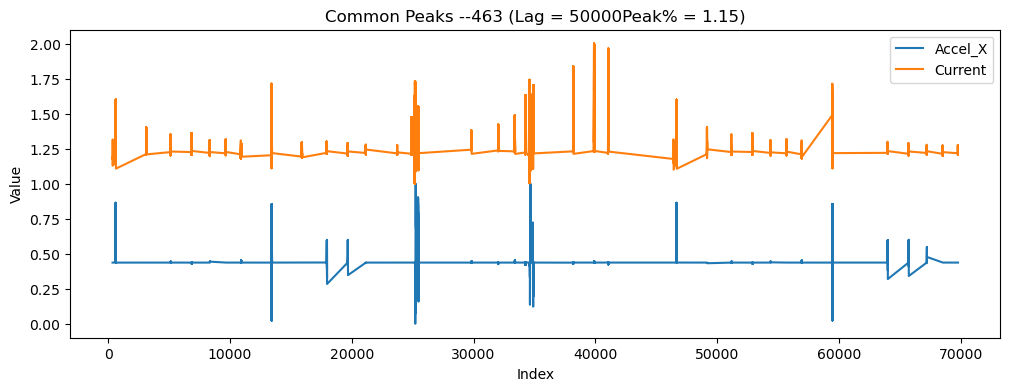

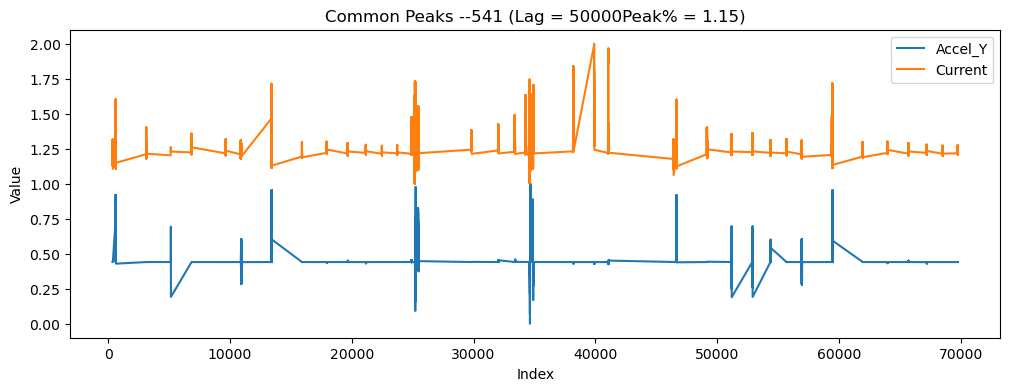

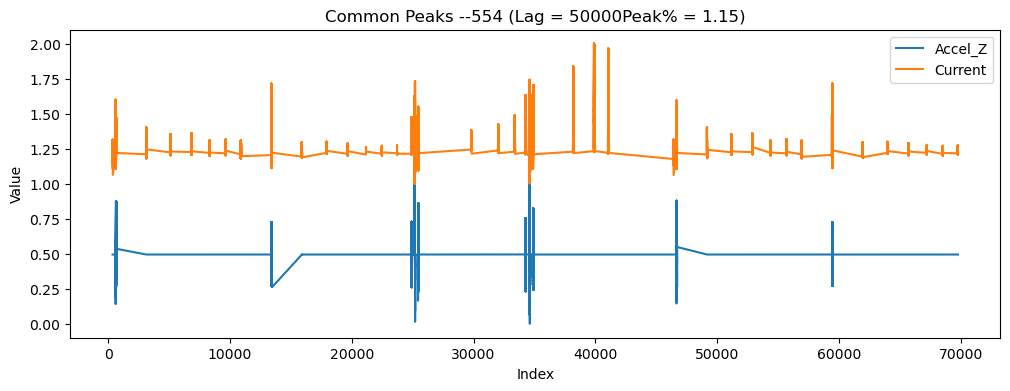

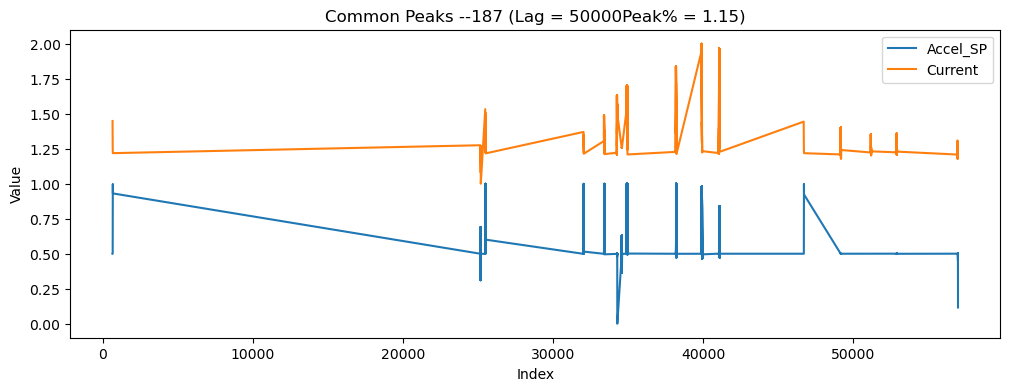

Currently on lag: 50000


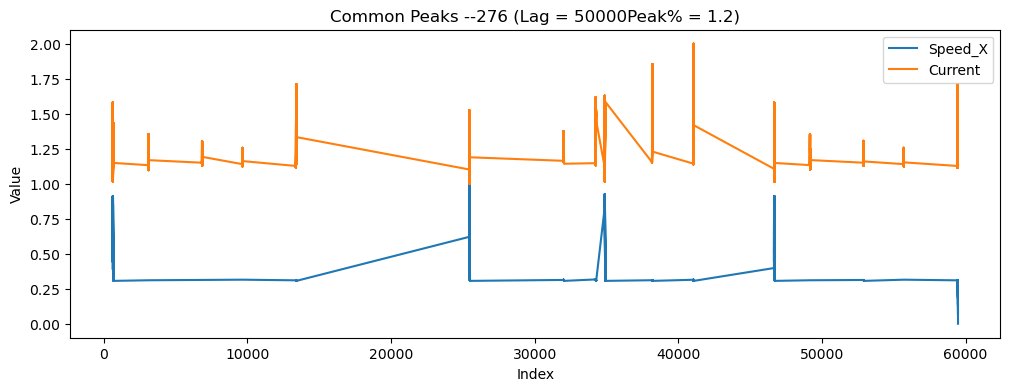

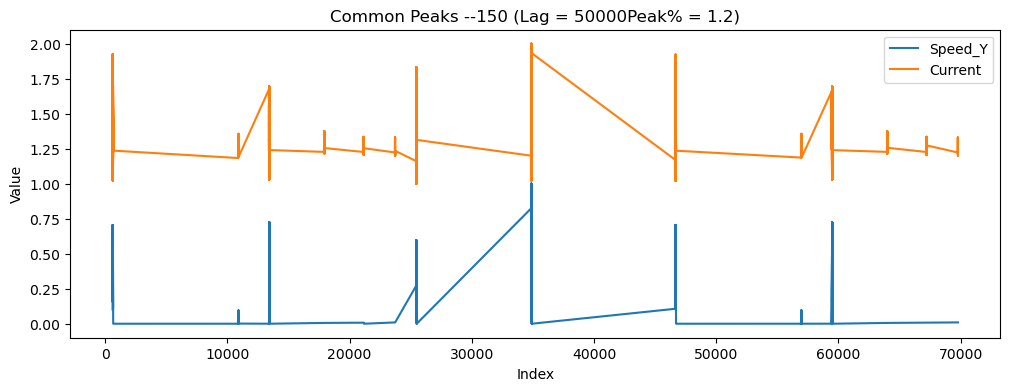

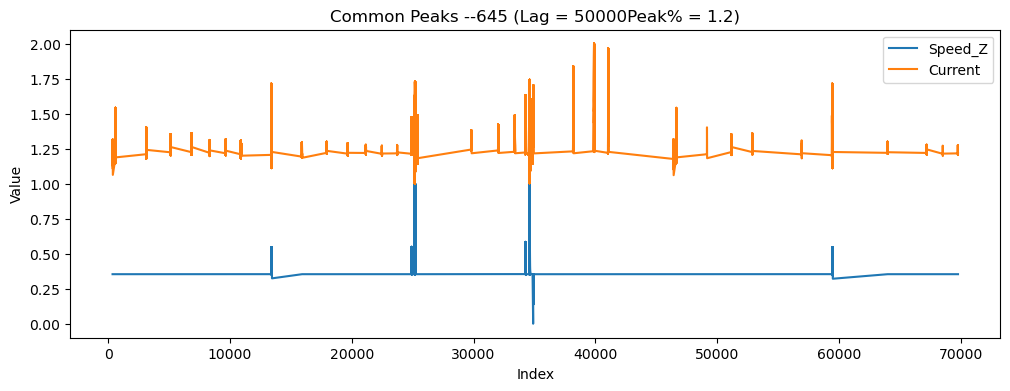

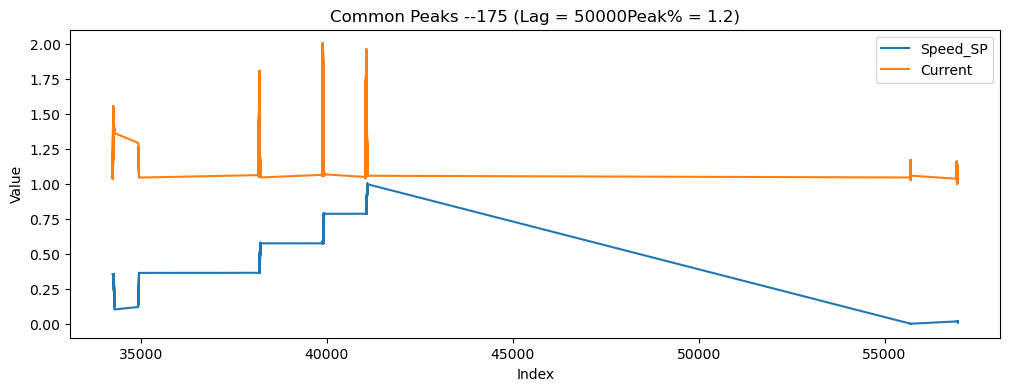

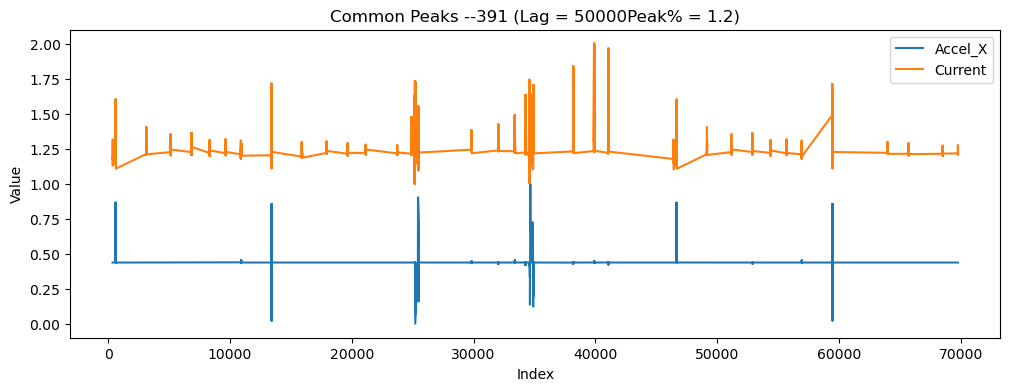

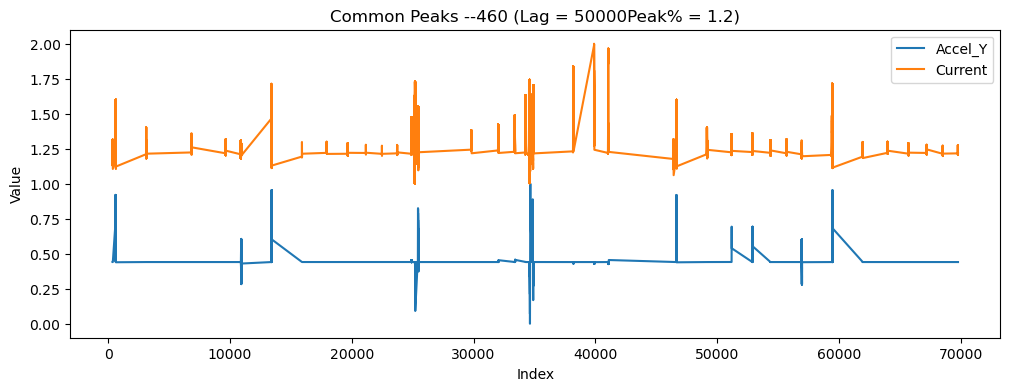

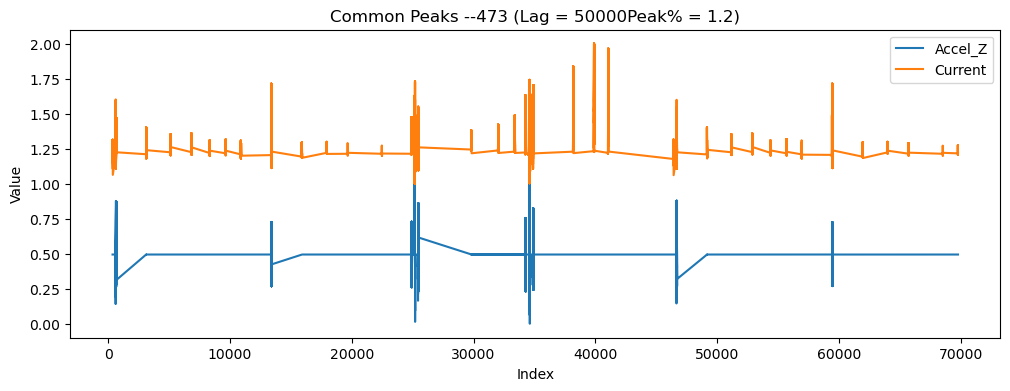

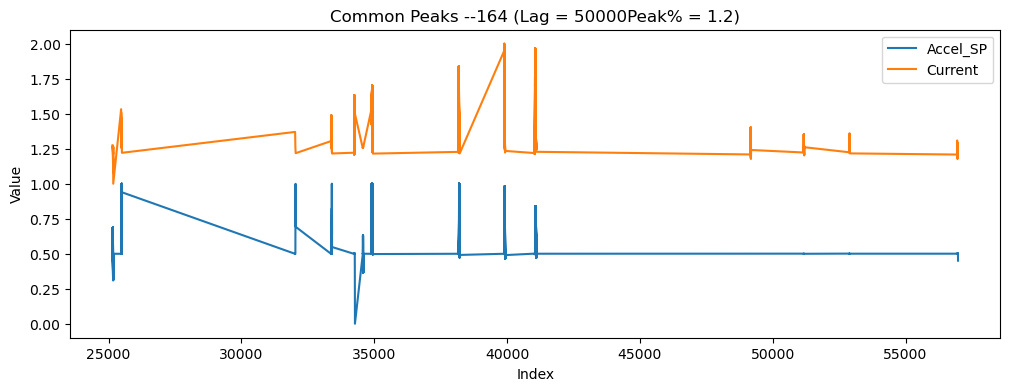

Currently on lag: 50000


In [46]:
lag = [10000, 30000, 50000]
percent = [1.1, 1.15, 1.2 ]
for lag_val in lag:
    for percent_val in percent:
        get_output_peaks(X_train, lag_val, percent_val)


# Peak Aware Model

We have chosen lag = 50000 as the parameter for the peak detection methods. Based on this, separate peaks and non-peaks into two different dfs.

In [12]:
peak_info = pd.read_excel('D:\Hiwi-TimeSeries\output\common_peaks_l_50000.xlsx')
max_peaks = peak_info[peak_info['num_peaks'] == peak_info['num_peaks'].max()]


Check if many features have common peaks or only one.

In [13]:
peak_indices_lists = max_peaks['peak_indices'].tolist()
all_indices_same = all(peak_indices == peak_indices_lists[0] for peak_indices in peak_indices_lists)
same = 0
if all_indices_same:
    same = 1
    print("All peak indices are the same across all rows.")
else:
    print("Peak indices are not the same across all rows.")


All peak indices are the same across all rows.


Based on that, create two dfs for peaks and non-peaks considering the selected feature(s).

In [14]:
column_name = eval(max_peaks['feature_pair'].iloc[0])[0]

In [15]:
def create_train_test_split(X_train, y_train, X_test, y_test, column_name):
    result = detect_peaks(X_train[column_name], 50000)
    peak_indices_train = result

    X_train_peak = X_train.loc[peak_indices_train]
    y_train_peak = y_train.loc[peak_indices_train]
    X_train_non_peak = X_train.drop(peak_indices_train)
    y_train_non_peak = y_train.drop(peak_indices_train)

    #Find peaks and non-peaks in test data
    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    result = detect_peaks(X_test[column_name], 50000)
    peak_indices_test = result

    X_test_peak = X_test.loc[peak_indices_test]
    y_test_peak = y_test.loc[peak_indices_test]
    X_test_non_peak = X_test.drop(peak_indices_test)
    y_test_non_peak = y_test.drop(peak_indices_test)

    return X_train_peak, y_train_peak, X_train_non_peak, y_train_non_peak, X_test_peak, y_test_peak, X_test_non_peak, y_test_non_peak

## Whole dataset using column with Max Common Peaks

In [20]:
X_train_peak, y_train_peak, X_train_non_peak, y_train_non_peak, X_test_peak, y_test_peak, X_test_non_peak, y_test_non_peak = create_train_test_split(X_train, y_train, X_test, y_test, column_name)

Build and train a Random Forest Regressor and Neural Network model for non-peak data

Mean Absolute Error: 0.12057774340774306
Mean Squared Error: 0.22776823776004088
Root Mean Squared Error: 0.4772507074484446
R-squared Score: 0.6794422220531107
Mean Absolute Percentage Error: 1.7242670377615792


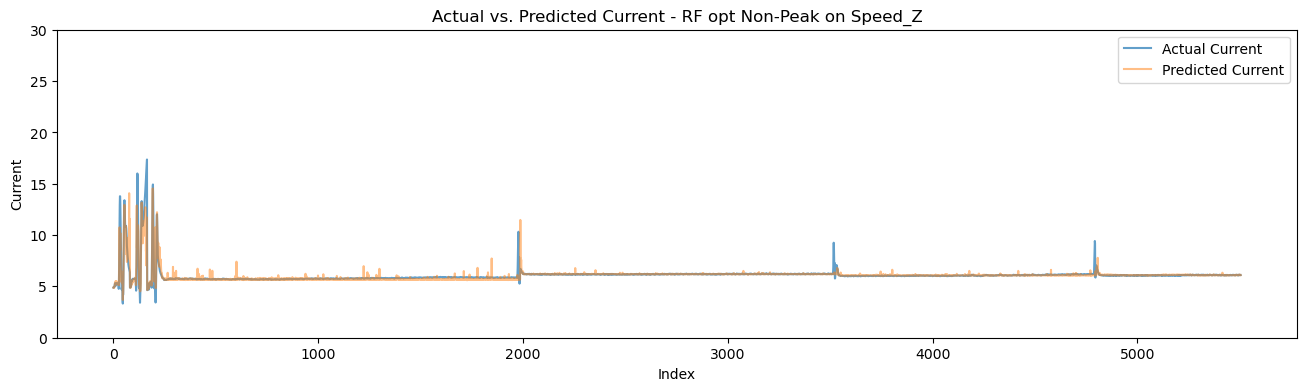

In [21]:
fit_predict(best_grid, X_train_non_peak, X_test_non_peak, y_train_non_peak, y_test_non_peak, 'RF opt Non-Peak on '+ column_name)

Build and train a RF and NN model for peak data

Mean Absolute Error: 0.10785198351165602
Mean Squared Error: 0.20011638131951207
Root Mean Squared Error: 0.4473436948471634
R-squared Score: 0.8059381011565366
Mean Absolute Percentage Error: 1.6797286931609208


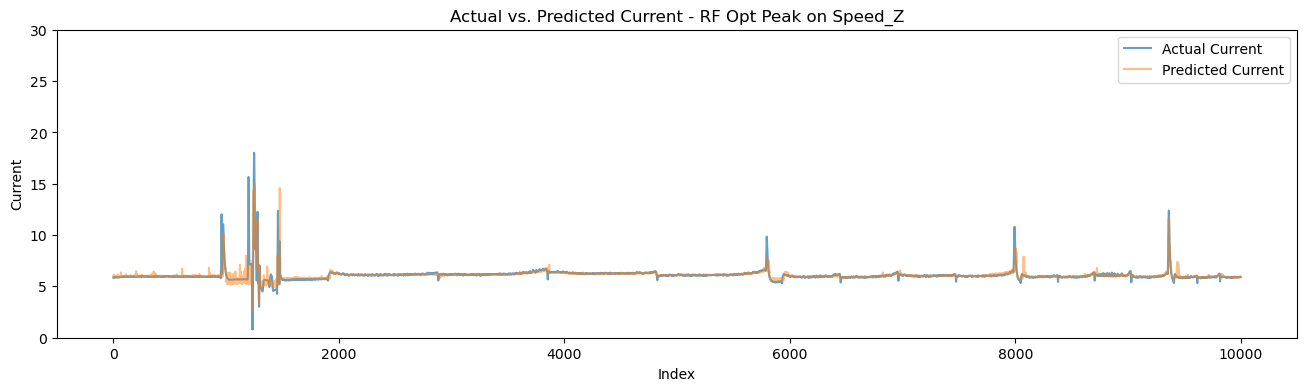

In [24]:
# New Peak detection
fit_predict(best_grid, X_train_peak, X_test_peak, y_train_peak, y_test_peak, 'RF Opt Peak on '+ column_name)

| Model                   |  MAE  |  MSE  |  RMSE |   R2  | MAPE  |
|-------------------------|-------|-------|-------|-------|-------|
| General RF Optimized    | 0.112 | 0.216 | 0.465 | 0.778 | 1.709 |
|                         |       |       |       |       |       |
| Global Random Forest    | 0.120 | 0.227 | 0.477 | 0.679 | 1.724 |
| Peak-Aware RF           | 0.107 | 0.200 | 0.447 | 0.805 | 1.679 |
|                         |       |       |       |       |       |
| Gen RF for Non-Peak     | 0.115 | 0.240 | 0.490 | 0.660 | 1.622 |

## Without using Global Models

Mean Absolute Error: 0.11513922933099022
Mean Squared Error: 0.2409881102608997
Root Mean Squared Error: 0.4909053984841679
R-squared Score: 0.660836761540741
Mean Absolute Percentage Error: 1.622082083178258


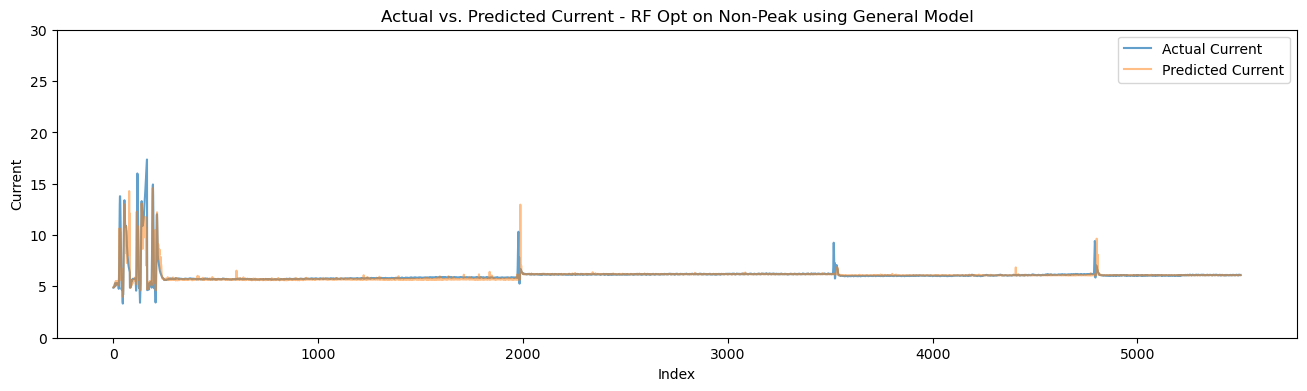

In [26]:
# New peak detection
fit_predict(best_grid, X_train, X_test_non_peak, y_train, y_test_non_peak, 'RF Opt on Non-Peak using General Model')